Reconhecimento de Padrões

Lista 4: Métodos estatatísticos e KNN


# Imports

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from scipy import stats

In [80]:
breast = pd.read_csv("content/breast.csv", header=None)
print(breast.shape)
breast.head()

(569, 31)


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


# Models

In [81]:
class Metrics():
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred

        TP = 0
        FP = 0
        FN = 0

        for i in range(len(self.y_pred)):
            if self.y_true.values[i] == 1 and self.y_pred[i] == 1:
                TP += 1
            elif self.y_true.values[i] == 0 and self.y_pred[i] == 1:
                FP += 1
            elif self.y_true.values[i] == 1 and self.y_pred[i] == 0:
                FN += 1
        TN = len(self.y_true) - TP - FP - FN
        TP, FP, FN, TN

        self.TP = TP
        self.FP = FP
        self.FN = FN
        self.TN = TN

        self.accuracy = (self.TP + self.TN) / \
            (self.TP + self.FP + self.FN + self.TN)
        self.precision = self.TP / (self.TP + self.FP)
        self.recall = self.TP / (self.TP + self.FN)
        if (self.precision + self.recall) != 0:
            self.f1_score = 2 * (self.precision * self.recall) / (self.precision + self.recall)

        self.confusion_matrix = np.array(
            [[self.TN, self.FN], [self.FP, self.TP]])

# KFolds

In [82]:
X_breast = breast.iloc[:, 0:-1]
y_breast = breast.iloc[:, -1]
y_breast = y_breast.astype('int64')

## Gaussian Discriminant Analysis (GDA)

In [83]:
class GDA():
  def __init__(self):
    self.log_proba = np.log(0.5)
    self.cov_matrix_k = []
    self.mean_k = []
    self.log_det_cov = []

  def fit(self, X, y):
    self.labels = np.sort(np.unique(y))
    for label in self.labels:
      X_k = X[y == label]
      self.cov_matrix_k.append(np.cov(X_k, rowvar=False))
      self.mean_k.append(np.mean(X_k, axis=0))
      self.log_det_cov.append(np.log(np.linalg.det(self.cov_matrix_k[label])))

  def predict(self, X):
    y_labels_proba = []
    for label in self.labels:
      central = (X - self.mean_k[label])
      inv_cov = np.linalg.inv(self.cov_matrix_k[label])

      y_labels_proba.append(self.log_proba - 1/2 * (self.log_det_cov[label] + central.T @ inv_cov @ central))

    return self.labels[np.argmax(y_labels_proba)]

In [84]:
gda = GDA()

kf = KFold(n_splits=10, shuffle=True, random_state=101)
kf.get_n_splits(X_breast)

accuracy = []
precision = []
recall = []
f1_score = []
sum_matrix = [[0,0],[0,0]]
for i, (train_index, test_index) in enumerate(kf.split(X_breast)):
    y_pred = []
    X_train_fold, X_test_fold = X_breast.iloc[train_index], X_breast.iloc[test_index]
    y_train_fold, y_test_fold = y_breast.iloc[train_index], y_breast.iloc[test_index]

    x_max = X_train_fold.max()
    x_min = X_train_fold.min()
    X_train_norm = (X_train_fold - x_min) / (x_max - x_min)
    X_test_norm = (X_test_fold - x_min) / (x_max - x_min)
    gda.fit(X_train_norm, y_train_fold.values)
    for x in X_test_norm.values:
        y_pred.append(gda.predict(x))
    metric = Metrics(y_test_fold, y_pred)
    

    accuracy.append(metric.accuracy)
    precision.append(metric.precision)
    recall.append(metric.recall)
    f1_score.append(metric.f1_score)
    sum_matrix += metric.confusion_matrix

print("\naccuracy:", np.mean(accuracy), "\nSTD:", np.std(accuracy))
print("\nprecision:", np.mean(precision), "\nSTD:", np.std(precision))
print("\nrecall:", np.mean(recall), "\nSTD:", np.std(recall))
print("\nf1_score:", np.mean(f1_score), "\nSTD:", np.std(f1_score))


accuracy: 0.9332706766917293 
STD: 0.09307717395692183

precision: 0.9828895461693451 
STD: 0.018732872602797292

recall: 0.9069713681451486 
STD: 0.16235899982087462

f1_score: 0.9336549410259017 
STD: 0.10110229884774498


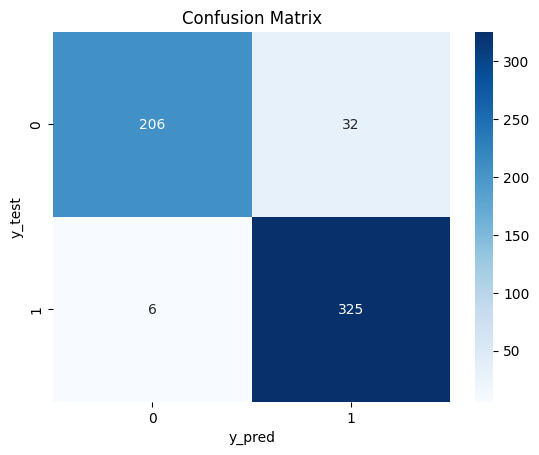

In [85]:
sns.heatmap(sum_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.title('Confusion Matrix')
plt.show()

## Gaussian Naive Bayes (GNB)

In [86]:
class GNB():
  def __init__(self):
    self.log_proba = np.log(0.5)
    self.mean_k = []
    self.var_k = []


  def fit(self, X, y):
    self.labels = np.sort(np.unique(y))
    for label in self.labels:
      X_k = X[y == label]
      self.var_k.append(np.var(X_k, axis=0)) 
      self.mean_k.append(np.mean(X_k, axis=0))

  def predict(self, X):
    y_labels_proba = []
    for label in self.labels:
      sum_central_squared_div = np.sum((X - self.mean_k[label])**2 / (self.var_k[label]))
      sum_log_var = np.sum(np.log(2 * np.pi * self.var_k[label]))

      y_labels_proba.append(self.log_proba - 1/2 * (sum_central_squared_div + sum_log_var))
    return self.labels[np.argmax(y_labels_proba)]

In [95]:
gnb = GNB()

kf = KFold(n_splits=10, shuffle=True, random_state=101)
kf.get_n_splits(X_breast)

accuracy = []
precision = []
recall = []
f1_score = []
sum_matrix = [[0,0],[0,0]]
for i, (train_index, test_index) in enumerate(kf.split(X_breast)):
    y_pred = []
    X_train_fold, X_test_fold = X_breast.iloc[train_index], X_breast.iloc[test_index]
    y_train_fold, y_test_fold = y_breast.iloc[train_index], y_breast.iloc[test_index]

    x_max = X_train_fold.max()
    x_min = X_train_fold.min()
    X_train_norm = (X_train_fold - x_min) / (x_max - x_min)
    X_test_norm = (X_test_fold - x_min) / (x_max - x_min)
    gnb.fit(X_train_norm, y_train_fold.values)
    for x in X_test_norm.values:
        y_pred.append(gnb.predict(x))
    metric = Metrics(y_test_fold, y_pred)
    

    accuracy.append(metric.accuracy)
    precision.append(metric.precision)
    recall.append(metric.recall)
    f1_score.append(metric.f1_score)
    sum_matrix += metric.confusion_matrix

print("\naccuracy:", np.mean(accuracy), "\nSTD:", np.std(accuracy))
print("\nprecision:", np.mean(precision), "\nSTD:", np.std(precision))
print("\nrecall:", np.mean(recall), "\nSTD:", np.std(recall))
print("\nf1_score:", np.mean(f1_score), "\nSTD:", np.std(f1_score))


accuracy: 0.9402882205513784 
STD: 0.029513938654829035

precision: 0.9452419037790556 
STD: 0.0342043707877327

recall: 0.9612265054490663 
STD: 0.02463615693171122

f1_score: 0.9527793651261949 
STD: 0.022930485219644966


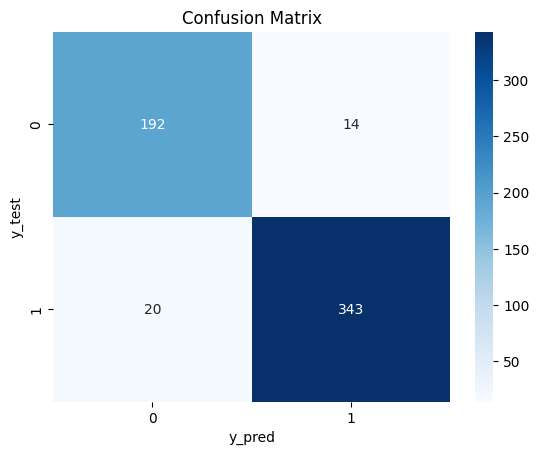

In [88]:
sns.heatmap(sum_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.title('Confusion Matrix')
plt.show()

## K Nearest Neighbor (KNN)

In [89]:
class KNN():
  def __init__(self, data, target):
    self.data = data
    self.target = target
    return

  def predict(self, x, k = 3):
    distances = []
    for i in range(len(self.data)):
      distances.append(np.sqrt(np.sum((self.data[i] - x)**2)))

    indices = np.argsort(distances)[:k]
    neighbors = self.target[indices]
    neighbors = np.sort(neighbors)
    mode, _ = stats.mode(neighbors)
    return mode

In [90]:
kf = KFold(n_splits=10, shuffle=True, random_state=101)
kf.get_n_splits(X_breast)

accuracy = []
precision = []
recall = []
f1_score = []
sum_matrix = [[0,0],[0,0]]
for i, (train_index, test_index) in enumerate(kf.split(X_breast)):
    y_pred = []
    X_train_fold, X_test_fold = X_breast.iloc[train_index], X_breast.iloc[test_index]
    y_train_fold, y_test_fold = y_breast.iloc[train_index], y_breast.iloc[test_index]

    knn = KNN(X_train_fold.values, y_train_fold.values)
    for x in X_test_fold.values:
        y_pred.append(knn.predict(x))
    metric = Metrics(y_test_fold, y_pred)
    

    accuracy.append(metric.accuracy)
    precision.append(metric.precision)
    recall.append(metric.recall)
    f1_score.append(metric.f1_score)
    sum_matrix += metric.confusion_matrix

print("\naccuracy:", np.mean(accuracy), "\nSTD:", np.std(accuracy))
print("\nprecision:", np.mean(precision), "\nSTD:", np.std(precision))
print("\nrecall:", np.mean(recall), "\nSTD:", np.std(recall))
print("\nf1_score:", np.mean(f1_score), "\nSTD:", np.std(f1_score))


accuracy: 0.919235588972431 
STD: 0.02730054204557919

precision: 0.9277697712357533 
STD: 0.029685924348102716

recall: 0.9445873338098949 
STD: 0.03711768345391915

f1_score: 0.935521432884958 
STD: 0.023946119159266463


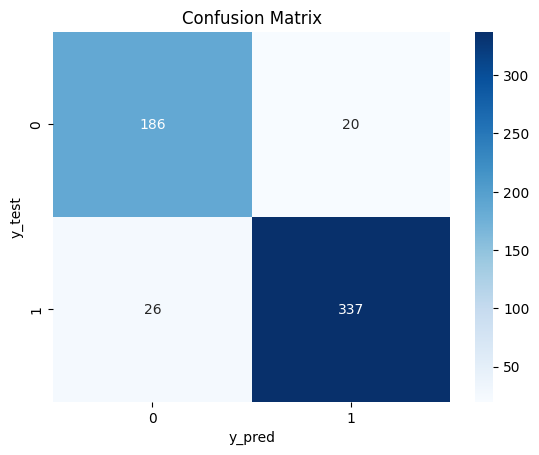

In [91]:
sns.heatmap(sum_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.title('Confusion Matrix')
plt.show()